In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "WOX"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn053291,MEFQQQNNQNQQQQQNEDGGSGSSKSTSFLCRQSSTRWTPTTDQIR...,290,1
1,Achn104531,MEEDANHPNSPISSSGGGDQRNNEPVRSRWTPKPEQILILESIFNS...,256,1
2,Achn107771,MILEEMYTRGGIRTPNASQIQQITAYLSLYGKIEGKNVFYWFQNHK...,139,1
3,Achn131681,MKVHHQLSRGLFDHEPFLTLDCKRLRPLAPKLIPDAHTHSSVGAAF...,207,1
4,Achn141001,MGCQAFALSRGSVAVVVVVLNVGGGIRRLNRSGLRTPSTDQIQKIS...,159,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
703,0.005556,0.0,0.000000,0.005556,0.000000,0.005556,0.005556,0.000000,0.005556,0.005556,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.005556,0.005556,0.0,0.000000
3994,0.003378,0.0,0.000000,0.006757,0.000000,0.006757,0.000000,0.000000,0.000000,0.003378,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2765,0.003839,0.0,0.003839,0.003839,0.001919,0.001919,0.000000,0.001919,0.001919,0.007678,...,0.000000,0.000000,0.0,0.000000,0.001919,0.000000,0.000000,0.000000,0.0,0.000000
4433,0.003690,0.0,0.001845,0.007380,0.000000,0.001845,0.000000,0.001845,0.003690,0.001845,...,0.000000,0.001845,0.0,0.001845,0.000000,0.001845,0.001845,0.000000,0.0,0.001845
4601,0.015228,0.0,0.002538,0.007614,0.002538,0.005076,0.005076,0.002538,0.007614,0.010152,...,0.002538,0.002538,0.0,0.000000,0.005076,0.000000,0.000000,0.000000,0.0,0.002538


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3745, 441)
X_test: (937, 441)
y_train: (3745,)
y_test: (937,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 21s 472ms/step - accuracy: 0.5156 - loss: 0.6931

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5832 - loss: 0.6797   

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6256 - loss: 0.6621 - val_accuracy: 0.9613 - val_loss: 0.2466


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.3269

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9635 - loss: 0.1697

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1586 - val_accuracy: 0.9853 - val_loss: 0.0571


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0355

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9775 - loss: 0.0665

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9786 - loss: 0.0638 - val_accuracy: 0.9853 - val_loss: 0.0480


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0893

34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0398

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0370 - val_accuracy: 0.9813 - val_loss: 0.0599


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0499

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.0342

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0301 - val_accuracy: 0.9893 - val_loss: 0.0495


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0023

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0191

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0197 - val_accuracy: 0.9773 - val_loss: 0.0638


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0110

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0150

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0149 - val_accuracy: 0.9880 - val_loss: 0.0513


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0125

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0125 - val_accuracy: 0.9840 - val_loss: 0.0568


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1133

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0233

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0200 - val_accuracy: 0.9853 - val_loss: 0.0550


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0077

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0071

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0073 - val_accuracy: 0.9840 - val_loss: 0.0554


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0027

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0036 - val_accuracy: 0.9773 - val_loss: 0.0745


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0186

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0186 - val_accuracy: 0.9826 - val_loss: 0.0658


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0059

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0068 - val_accuracy: 0.9880 - val_loss: 0.0563


Epoch 14/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0058

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0053 - val_accuracy: 0.9826 - val_loss: 0.0645


Epoch 15/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0055

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0017

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9866 - val_loss: 0.0635



[Train Accuracy: 99.97% - Test Accuracy: 98.83%]


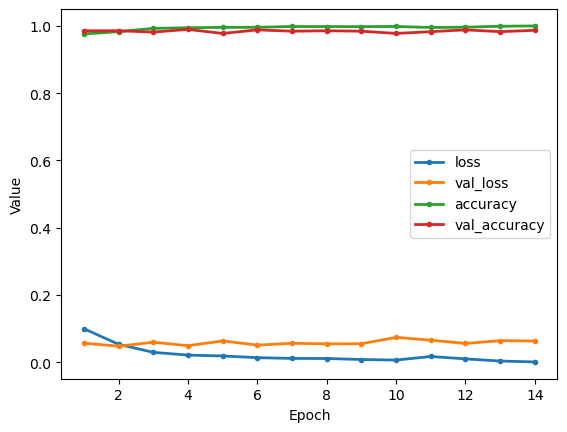

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
703,0.0,0.0,0.0,0.0,0.0,0.005587,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2765,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001923,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4433,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.001848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4601,0.0,0.0,0.0,0.0,0.0,0.000000,0.002545,0.002545,0.002545,0.0,...,0.002545,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3745, 8658)
X_test: (937, 8658)
y_train: (3745,)
y_test: (937,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,216,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,969 (8.62 MB)

 Trainable params: 2,259,969 (8.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 21s 473ms/step - accuracy: 0.5156 - loss: 0.6932

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5234 - loss: 0.6929   

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5369 - loss: 0.6919

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5532 - loss: 0.6887

35/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5860 - loss: 0.6819

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6193 - loss: 0.6695

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6329 - loss: 0.6619 - val_accuracy: 0.9920 - val_loss: 0.1723


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.1981

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9856 - loss: 0.1505 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9867 - loss: 0.1264

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9875 - loss: 0.1105

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9885 - loss: 0.0980

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9893 - loss: 0.0885

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9894 - loss: 0.0867 - val_accuracy: 0.9947 - val_loss: 0.0269


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0011

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9955 - loss: 0.0202 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9966 - loss: 0.0163

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0151

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0139

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0130

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0130 - val_accuracy: 0.9947 - val_loss: 0.0257


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0074

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0082 

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0086

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0082

35/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0077

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0072

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0070 - val_accuracy: 0.9947 - val_loss: 0.0212


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0021

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017 

18/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

27/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9947 - val_loss: 0.0264


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.8711e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8445e-04 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0253e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7972e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 7.6761e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 8.8135e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 8.9736e-04 - val_accuracy: 0.9947 - val_loss: 0.0250


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.0245e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1300e-04 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1779e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4794e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6036e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6627e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6740e-04 - val_accuracy: 0.9947 - val_loss: 0.0265


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.3027e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0599e-04 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2529e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4116e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4892e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5528e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5647e-04 - val_accuracy: 0.9947 - val_loss: 0.0283


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.4090e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3293e-04 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8673e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7072e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6042e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5219e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5184e-04 - val_accuracy: 0.9947 - val_loss: 0.0329


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.8830e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6559e-05 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7777e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6474e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1191e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3260e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3498e-04 - val_accuracy: 0.9947 - val_loss: 0.0315


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.6703e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5137e-05 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4645e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4809e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4525e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4500e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4503e-05 - val_accuracy: 0.9947 - val_loss: 0.0357


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.7277e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1261e-05 

19/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4292e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1677e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9881e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1517e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2506e-05 - val_accuracy: 0.9947 - val_loss: 0.0299



[Train Accuracy: 100.00% - Test Accuracy: 99.57%]


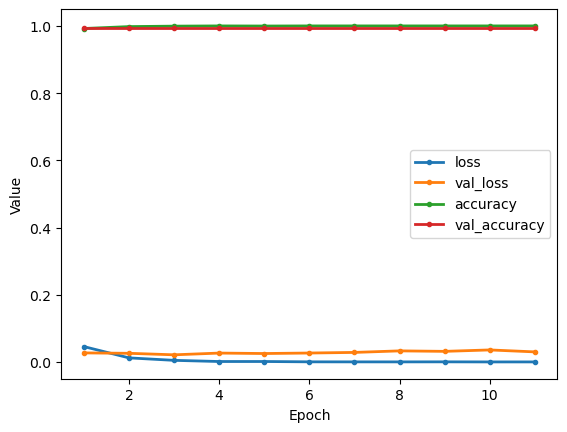

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,509,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,550,977 (135.62 MB)

 Trainable params: 35,550,977 (135.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 29s 651ms/step - accuracy: 0.4844 - loss: 0.6931

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.4922 - loss: 0.6931 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.5000 - loss: 0.6930

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5020 - loss: 0.6930

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.5047 - loss: 0.6929

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.5082 - loss: 0.6928

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5096 - loss: 0.6927

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.5106 - loss: 0.6926

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5110 - loss: 0.6925

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5107 - loss: 0.6924

11/47 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5102 - loss: 0.6923

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5106 - loss: 0.6922

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5101 - loss: 0.6921

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5106 - loss: 0.6919

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.5109 - loss: 0.6918

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5117 - loss: 0.6916

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5131 - loss: 0.6915

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5148 - loss: 0.6913

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.5171 - loss: 0.6911

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.5199 - loss: 0.6908

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5230 - loss: 0.6905

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5263 - loss: 0.6903

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5296 - loss: 0.6899

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5331 - loss: 0.6896

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5367 - loss: 0.6892

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5403 - loss: 0.6888

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5441 - loss: 0.6883

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.5479 - loss: 0.6878

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5517 - loss: 0.6873

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5557 - loss: 0.6868

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5596 - loss: 0.6862

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5636 - loss: 0.6856

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5676 - loss: 0.6849

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5714 - loss: 0.6842

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5753 - loss: 0.6834

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5790 - loss: 0.6826

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5828 - loss: 0.6817

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5865 - loss: 0.6808

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5902 - loss: 0.6798

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5938 - loss: 0.6788

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5974 - loss: 0.6777

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6009 - loss: 0.6766

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6044 - loss: 0.6754

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6079 - loss: 0.6741

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6113 - loss: 0.6728

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6147 - loss: 0.6713

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6180 - loss: 0.6699

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.6212 - loss: 0.6685 - val_accuracy: 0.9706 - val_loss: 0.2912


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9219 - loss: 0.2840

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9297 - loss: 0.2833

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9375 - loss: 0.2772

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9404 - loss: 0.2716

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9442 - loss: 0.2652

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9479 - loss: 0.2591

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9509 - loss: 0.2533

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9536 - loss: 0.2477

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9560 - loss: 0.2422

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9582 - loss: 0.2370

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9601 - loss: 0.2324

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9616 - loss: 0.2284

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9629 - loss: 0.2246

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9641 - loss: 0.2208

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9652 - loss: 0.2171

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9663 - loss: 0.2134

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9673 - loss: 0.2098

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9683 - loss: 0.2063

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9692 - loss: 0.2028

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9700 - loss: 0.1994

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9707 - loss: 0.1962

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9714 - loss: 0.1930

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9720 - loss: 0.1899

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9726 - loss: 0.1870

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9732 - loss: 0.1842

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9738 - loss: 0.1815

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9743 - loss: 0.1788

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9748 - loss: 0.1762

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9753 - loss: 0.1737

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9757 - loss: 0.1713

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9761 - loss: 0.1690

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9765 - loss: 0.1667

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9769 - loss: 0.1645

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9773 - loss: 0.1624

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9776 - loss: 0.1603

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9780 - loss: 0.1584

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9783 - loss: 0.1564

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9786 - loss: 0.1546

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9789 - loss: 0.1527

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9792 - loss: 0.1509

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9795 - loss: 0.1492

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9797 - loss: 0.1475

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9800 - loss: 0.1459

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9802 - loss: 0.1443

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9805 - loss: 0.1427

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9807 - loss: 0.1412

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9809 - loss: 0.1398

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9811 - loss: 0.1383 - val_accuracy: 0.9973 - val_loss: 0.0146


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9844 - loss: 0.0167

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9883 - loss: 0.0138

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9905 - loss: 0.0123

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9919 - loss: 0.0112

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9929 - loss: 0.0104

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9936 - loss: 0.0097

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9942 - loss: 0.0092

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9947 - loss: 0.0087

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9951 - loss: 0.0083

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9954 - loss: 0.0079

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9957 - loss: 0.0076

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9960 - loss: 0.0073

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9962 - loss: 0.0070

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9964 - loss: 0.0068

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9965 - loss: 0.0066

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9967 - loss: 0.0064

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9968 - loss: 0.0063

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9970 - loss: 0.0061

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9971 - loss: 0.0060

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.9972 - loss: 0.0059

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9973 - loss: 0.0057

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9974 - loss: 0.0056

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9975 - loss: 0.0055

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9975 - loss: 0.0054

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9976 - loss: 0.0053

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9977 - loss: 0.0053

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9977 - loss: 0.0052

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9978 - loss: 0.0051

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9979 - loss: 0.0050

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9979 - loss: 0.0050

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9980 - loss: 0.0049

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9980 - loss: 0.0048

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9981 - loss: 0.0048

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9981 - loss: 0.0047

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9981 - loss: 0.0046

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9982 - loss: 0.0046

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9982 - loss: 0.0045

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9982 - loss: 0.0045

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9983 - loss: 0.0045

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9983 - loss: 0.0044

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9983 - loss: 0.0044

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9983 - loss: 0.0043

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0043

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0043

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0043

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0042

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9984 - loss: 0.0042

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9985 - loss: 0.0042 - val_accuracy: 0.9973 - val_loss: 0.0110


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 1.0000 - loss: 0.0027

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0026

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0024

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0023

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0022

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0021

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0021

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0020

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0020

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0019

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0019

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0019

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0018

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0018

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0018

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0018

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0017

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0017

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0017

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0016

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0016

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0016

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 0.0016

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 0.0016

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0016

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0016

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0016

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0016

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0015

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0015

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0015

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0015

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0015

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0015

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0015

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0015

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0015

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0014

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0014

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0014

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0014

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9973 - val_loss: 0.0105


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 0.0010

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 9.7242e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.2500e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.8619e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 8.5438e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.2543e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 8.1571e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 8.0332e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.8924e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 7.7541e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 7.6207e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.5029e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.3891e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 7.2829e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.1873e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.1026e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 7.0313e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.9643e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.9227e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.8919e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.8566e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.8195e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.7784e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.7347e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.6914e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.6494e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.6075e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 6.5649e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 6.5211e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 6.4787e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 6.4381e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 6.4004e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 6.3629e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 6.3258e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 6.2885e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 6.2585e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 6.2294e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 6.2008e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 6.1721e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 6.1429e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 6.1132e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 6.0839e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 6.0545e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 6.0249e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.9967e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.9685e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.9409e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 5.9145e-04 - val_accuracy: 0.9973 - val_loss: 0.0146


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 1.0000 - loss: 3.0988e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.0476e-04 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.9880e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 2.8942e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.7994e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.7182e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 2.7103e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.7515e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.8179e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.8608e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 2.9043e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.9375e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.9621e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.9778e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.9881e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.9966e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 3.0017e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 3.0029e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.9988e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.9966e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9966e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9972e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9946e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9923e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9914e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9889e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9849e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9838e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.9818e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9790e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9753e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9718e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9678e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9768e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9836e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9885e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9928e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 2.9958e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 2.9985e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 2.9999e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0006e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0006e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0041e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0090e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0128e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0179e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0220e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 3.0260e-04 - val_accuracy: 0.9973 - val_loss: 0.0129


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.1246e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 2.3860e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 2.6392e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.7958e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 2.8548e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.8825e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.9015e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.8915e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 2.8640e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.8682e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 2.8576e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.8426e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.8253e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.8111e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.7944e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.7835e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.7703e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.7724e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.7804e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.7839e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.7833e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.7835e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.7804e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.7746e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.7686e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.7604e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.7515e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.7412e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.7313e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.7238e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7155e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7124e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.7088e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.7044e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.6999e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.6956e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 2.6913e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.6873e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 2.6824e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6772e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6716e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6657e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6592e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6527e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6457e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6392e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.6329e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 2.6268e-04 - val_accuracy: 0.9973 - val_loss: 0.0149


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.2506e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 1.9607e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.8392e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.7322e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.6900e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.6549e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.6128e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.5838e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.5638e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.5476e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.5305e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.5159e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.5011e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.4848e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.4686e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.4564e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.4443e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.4310e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.4176e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.4038e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 1.3904e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3774e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3654e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3537e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3423e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3364e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3298e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3229e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.3164e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.3102e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.3044e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.2987e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.2959e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.2928e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.2904e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.2885e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.2869e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.2851e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2844e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2835e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2832e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2825e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2826e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2823e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2819e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2812e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.2805e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 1.2799e-04 - val_accuracy: 0.9973 - val_loss: 0.0152


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.1989e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.0951e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.1008e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.0822e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.0541e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.0203e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 1.0014e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 9.8366e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.8384e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.8200e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.7970e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.7587e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.7017e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.6387e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.5789e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.5218e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.4628e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.4122e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.3543e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 9.2923e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.2427e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.1903e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.1347e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.0787e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 9.0240e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 8.9704e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.9342e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.8973e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 8.8620e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.8262e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 8.7928e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.7593e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.7268e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.7073e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.6845e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.6660e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.6570e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 8.6451e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.6328e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.6188e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.6031e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.5909e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 8.6166e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.6418e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 8.6634e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 8.6815e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 8.6980e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 8.7138e-05 - val_accuracy: 0.9973 - val_loss: 0.0164


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.3779e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 4.2916e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 4.5419e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 4.6184e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.6963e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.8900e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.3487e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.6630e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.8589e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.9884e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 6.2902e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.5757e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.8118e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 6.9801e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.1012e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 7.2061e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.2779e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.3386e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.3760e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 7.4052e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4240e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4371e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4568e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4679e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4707e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4663e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4631e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4534e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 7.4420e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.4260e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.4063e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.3835e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.3609e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.3360e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.3096e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.2815e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.2595e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 7.2363e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.2129e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.1908e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.1681e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.1451e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.1219e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.0980e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.0736e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.0554e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 7.0375e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 7.0203e-05 - val_accuracy: 0.9973 - val_loss: 0.0168


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.8488e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 2.1377e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 2.5694e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9830e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.3676e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 3.5816e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.8059e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 3.9372e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 4.0111e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 4.0807e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.1349e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.2715e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.3819e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.4585e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.5348e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.5943e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.6338e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.6684e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.6932e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.7075e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.7142e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 4.7220e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 4.7268e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 4.7276e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 4.7231e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 4.7156e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 4.7043e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.6923e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 4.6820e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.6690e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.6558e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.6413e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.6306e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.6181e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.6048e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.5953e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.5852e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 4.5746e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 4.5703e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 4.5645e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 4.5578e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 4.5535e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 4.5485e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 4.5425e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 4.5361e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 4.5292e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 4.5228e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 4.5168e-05 - val_accuracy: 0.9973 - val_loss: 0.0174


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 1.0000 - loss: 2.3072e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 4.2033e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 1.0000 - loss: 4.9372e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 5.0437e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.1654e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.1546e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.1073e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.0714e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.0101e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 4.9384e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 4.8554e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.7763e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.7030e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.6276e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 4.5540e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 4.4824e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 4.4456e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 4.4056e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 4.3655e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.3358e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.3037e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.2763e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.2475e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.2191e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.1895e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.1672e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.1443e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.1219e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 4.0994e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.0777e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.0562e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.0346e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.0126e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 3.9938e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 3.9752e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 3.9574e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 3.9395e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 3.9213e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 3.9030e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.8854e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.8709e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.8572e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.8442e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.8312e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.8179e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.8060e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 3.7940e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 3.7824e-05 - val_accuracy: 0.9973 - val_loss: 0.0178



[Train Accuracy: 100.00% - Test Accuracy: 99.57%]


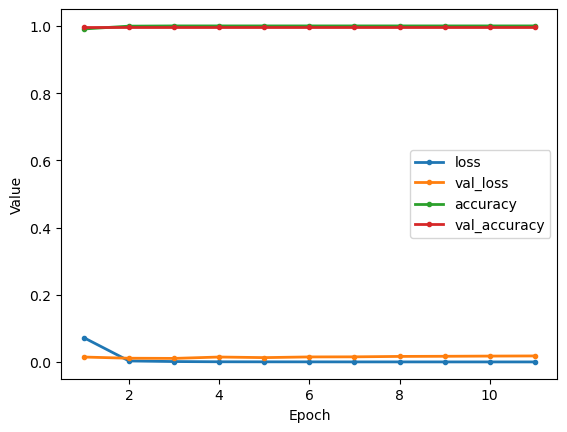

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

 7/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step

 7/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [25]:
report.save()

Report saved as Output/Reports/WOX/report_KU14I0R1.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################